# Ensemble Learning
Ensemble Learning이란, 다수의 Weak Learner들을 이용하여 하나의 높은 일반화 성능을 가지는 방법론을 의미한다. 이는 Bias-Variance Tradeoff 관계를 이용한다고 할 수 있다. 

<figure class="center">
    <img src="Bias_and_variance_contributing_to_total_error.png" title="Bias-Variance Trade off" height="200">
<figure>
이미지 출처 : https://en.wikipedia.org/wiki/Bias–variance_tradeoff

Bias-Variance Tradeoff란 머신러닝 등의 모델을 학습하는 방법론들이 각 샘플 데이터셋에 대해 학습했을 때, 개별 데이터셋으로 학습된 모델들의 예측값과 실제값 사이의 분산과 편향의 tradeoff 관계를 의미한다. 모델의 복잡도가 올라갈수록 샘플 데이터셋에 과적합되어 편향이 커지지만, 분산은 작아진다. 반대로, 모델의 복잡도가 낮아질수록 샘플 데이터셋에 과소적합되어 편향은 작아지지만, 분산이 커지게 된다. 즉, 단일 모델은 복잡도에 따른 일반화 성능의 한계가 존재한다. 하지만 각 모델이 가진 편향이 다르다면, 즉, 한 인스턴스에 대한 모델들의 예측값이 매우 다양하다면, 해당 모델들의 예측값을 이용하여 더욱 일반화 성능을 높일 수 있다. 이러한 방법론을 Ensemble Learning이라 한다. 


## Boosting & Bagging
이번 시간엔 앙상블 방법론의 대표적인 부스팅과 배깅을 중심으로 살펴볼 예정이다. 
- 부스팅은 복잡도가 매우 낮은 Stump tree를 Base Learner로 이용하여, 각 Base Learner가 이전 Base Learner 잔차 혹은 그래디언트를 학습 목표로 한다. 이를 통해 분산이 크고, 편향이 낮은 각 Base Learner들을 종합하여 분산을 낮춘 앙상블 방법론을 학습하는 것을 목표로 한다. 
- 배깅은 복잡도가 매우 높은 깊은 tree를 Base Learener로 이용하여, 각 Base Learner가 개별적인 학습을 진행한다. 이를 통해 분산은 작고, 편향이 큰 각 Base Learner들을 종합하여 편향을 낮춘 앙상블 방법론을 학습하는 것을 목표로 한다. 

### 0. Data Generation
- 동일한 실험 진행을 위해 간단한 이진 분류 데이터셋을 생성하여 사용하도록 하자.
- 현실적인 상황을 가정하기 위해 다음과 같은 환경을 설정했다. 
1. 데이터 수 : 1000개, 데이터가 매우 많은 상황이 아니다. 모델의 복잡도가 지나치게 높아지면, 편향이 커져 일반화 성능이 떨어질 것이다. 
2. 변수 수: 10개
3. 유의미한 변수 수 : 5개, 모든 변수가 유의미하지 않다. 트리 기반의 모델이 유의미한 변수를 Information Gain을 통해 잘 선택해야 할 것이다. 
4. 무의미한 변수 수 : 5개, 유의미하지 않은 변수가 다수 존재한다. 해당 변수들은 y와 직접적 관련성이 없으나, 유의미한 변수들의 무작위 조합을 통해 생성되므로, 실제 모델링 시 성능향상의 여지가 있다. 

In [23]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

X, y = make_classification(n_samples=2500, n_features = 20, n_informative = 5, n_redundant = 5, n_classes = 5, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 500, random_state = 0)

<AxesSubplot:>

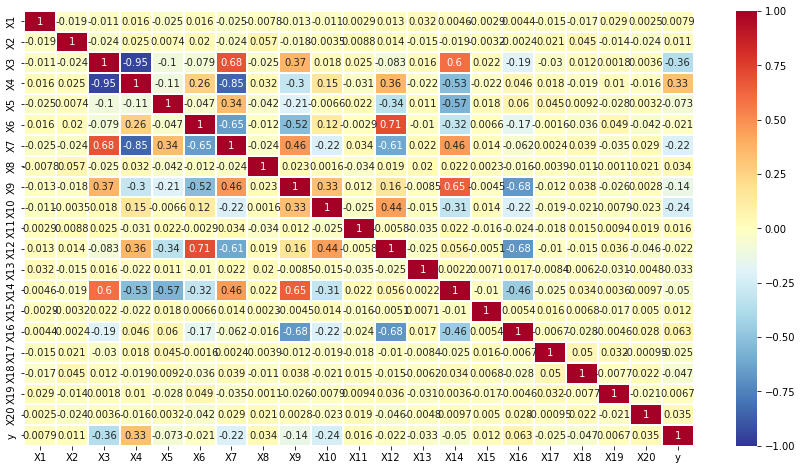

In [27]:
corr_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis = 1)
corr_df.columns = ['X' + str(i) for i in range(1, 21)] + ['y']
plt.figure(figsize=(15,8))
sns.heatmap(corr_df.corr(), cmap = 'RdYlBu_r', vmin = -1 , vmax = 1, annot = True, linewidths = 0.2)

변수 간 선형관계를 파악하는 것이 매우 어려운 상황임을 알 수 있다. 하지만 다양한 변수들이 매우 높은 다중공선성을 지니고 있으며, 19번 변수와 같이 거의 모든 변수에 독립적인 변수 역시 존재함을 확인할 수 있다. 

<AxesSubplot:>

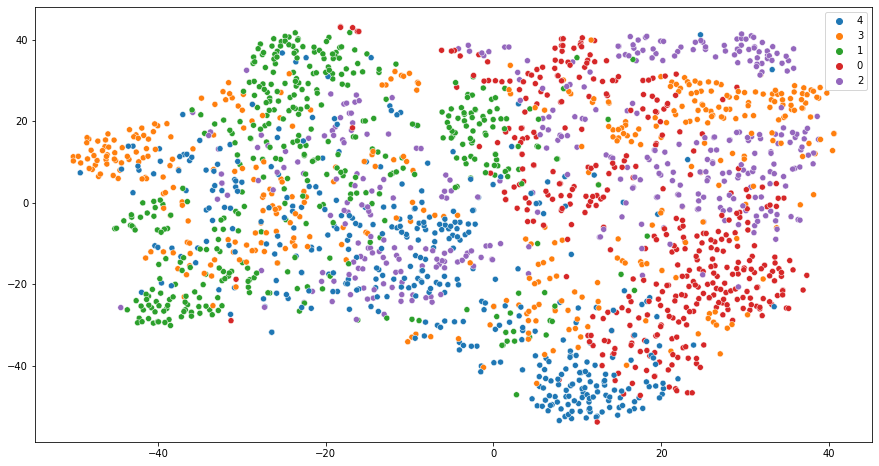

In [29]:
tsne = TSNE(n_components = 2, random_state = 0)
X_train_tsne = tsne.fit_transform(X_train)
plt.figure(figsize=(15,8))
sns.scatterplot(x = X_train_tsne[:,0], y = X_train_tsne[:,1], hue = [str(lab) for lab in y_train])

생성된 데이터가 어느정도 잘 분류될 수 있는 것을 확인할 수 있다. 노이즈가 상당히 존재하므로, 각 실험에 사용되는 방법론이 노이즈에 강건한 정도가 중요 관찰 지점이 될 수 있다. 

### 1. Random Forest
- Bagging 방법론 중 가장 대표적인 Random Forest를 통해 실험해보도록 하자. 

#### 1-1. Base Model 
Scikit Learn 라이브러리의 기본적인 하이퍼파라미터를 이용하여 성능을 측정해보자. 

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf_result_dict = {}
rf_clf_base = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_clf_base.fit(X_train, y_train)
rf_result_dict["base"] = rf_clf_base.score(X_test, y_test)

#### 1-2. Base Learner의 수 
앙상블 방법론은 Base Learner를 조합하여 최종 예측값을 산출하므로, Base Learner의 수에 의존적일 수밖에 없다. 하지만 너무 많은 Base Learner는 학습에 소요되는 시간이 매우 커질 우려가 있다. 이를 실험을 통해 살펴보자. 

In [31]:
rf_clf_base10 = RandomForestClassifier(n_estimators = 10, random_state = 0)
rf_clf_base10.fit(X_train, y_train)
rf_result_dict["base10"] = rf_clf_base10.score(X_test, y_test)

rf_clf_base500 = RandomForestClassifier(n_estimators = 500, random_state = 0)
rf_clf_base500.fit(X_train, y_train)
rf_result_dict["base500"] = rf_clf_base500.score(X_test, y_test)

rf_clf_base1000 = RandomForestClassifier(n_estimators = 1000, random_state = 0)
rf_clf_base1000.fit(X_train, y_train)
rf_result_dict["base1000"] = rf_clf_base1000.score(X_test, y_test)

In [32]:
rf_result_dict

{'base': 0.776, 'base10': 0.73, 'base500': 0.782, 'base1000': 0.776}

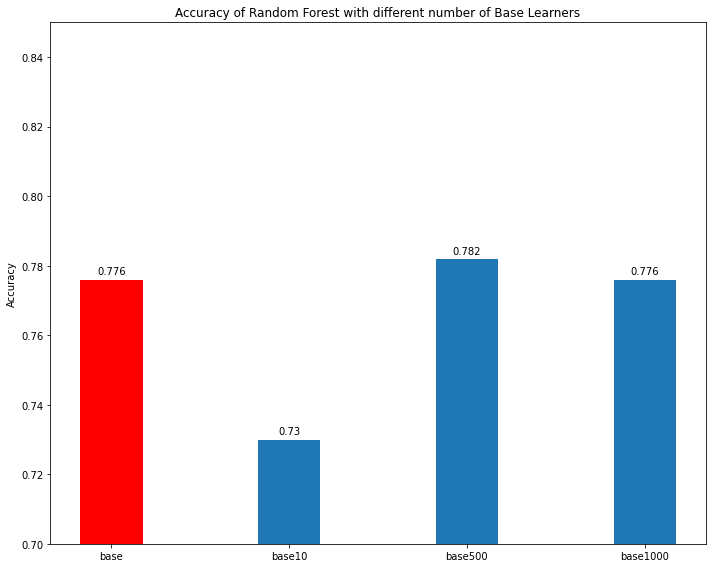

In [34]:
x = np.arange(len(rf_result_dict))
width = 0.35

fig, ax = plt.subplots()

rects1 = ax.bar(x , rf_result_dict.values(), width, label="num of Base Learners")
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Random Forest with different number of Base Learners')
ax.set_xticks(x)
ax.set_xticklabels(rf_result_dict.keys())
ax.set_ylim(0.7, 0.85)
ax.bar_label(rects1, padding=3)

# change figure size and bar color
fig.set_size_inches(10, 8)
rects1[0].set_color('r')

fig.tight_layout()
plt.show()

생각과 달리 base Learner의 수가 큰 영향을 미치지 못하는 모습을 볼 수 있다. 하지만 Base Learner의 수가 너무 적을 경우 성능이 상당히 저하되는 것을 확인 할 수 있으며, 이는 일정 수준 이상의 Base Learner 수를 확보해야 다양한 Base Learner를 통해 전체 모델을 구성할 수 있기 때문으로 추정된다. 

#### 1-3. Base Learner Depth
배깅 방식은 매우 강한 Base Learner를 사용하여 각 Base Learner 간 편향을 높이고, 분산을 의도적으로 낮추고 있다. 만약, 반대로 깊이가 매우 얕은 Base Learner를 사용하면 성능이 어떤 모습을 띌까?

In [35]:
depth_list = []
score_list = []
from numpy import mean
for tree in rf_clf_base.estimators_:
    depth_list.append(tree.tree_.max_depth)
    score_list.append(tree.score(X_test, y_test))
print(f">>> base model: max_depth = {mean(depth_list)}, mean score = {mean(score_list)}, max score = {max(score_list)}")

>>> base model: max_depth = 18.25, mean score = 0.5695799999999999, max score = 0.63


예상과 같이 각 Base Learner의 평균 깊이는 18.25로 변수 갯수를 고려할 때 상당히 깊은 편이다. 또한, Base Learner의 평균 성능은 56.96, 최고 성능은 63으로 전체 모델의 성능 77.6에 비해 상당히 낮은 것을 확인할 수 있다. 매우 낮은 성능의 Base Learner의 조합을 통해 높은 성능을 확보하는 Ensemble 방식의 특징이 두드러지는 결과라 할 수 있다. 다음으로 Base Learner의 깊이를 제한하여 실험을 진행해보자. 

In [36]:
rf_clf_depth2 = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 0)
rf_clf_depth2.fit(X_train, y_train)
rf_result_dict["depth2"] = rf_clf_depth2.score(X_test, y_test)

rf_clf_depth5 = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 0)
rf_clf_depth5.fit(X_train, y_train)
rf_result_dict["depth5"] = rf_clf_depth5.score(X_test, y_test)

rf_clf_depth10 = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 0)
rf_clf_depth10.fit(X_train, y_train)
rf_result_dict["depth10"] = rf_clf_depth10.score(X_test, y_test)

rf_result_dict

{'base': 0.776,
 'base10': 0.73,
 'base500': 0.782,
 'base1000': 0.776,
 'depth2': 0.556,
 'depth5': 0.696,
 'depth10': 0.774}

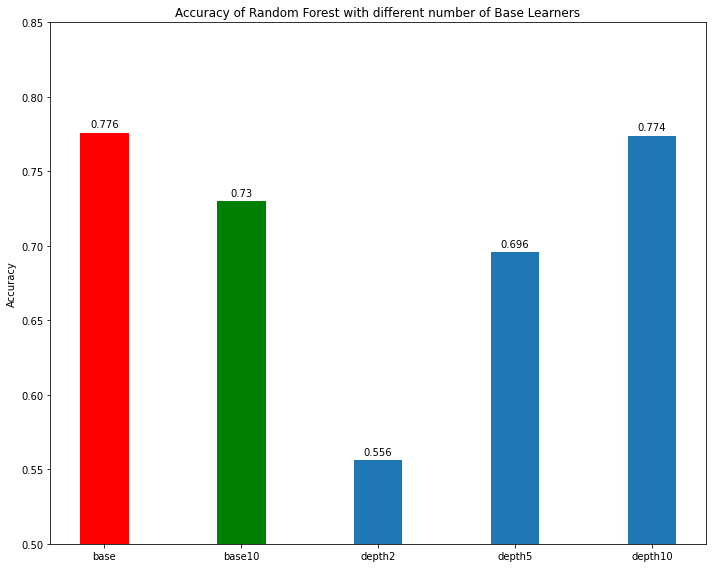

In [38]:
result_vis_dict = {key : value for key, value in rf_result_dict.items() if key in ["base", "base10", "depth2", "depth5", "depth10"]}
x = np.arange(len(result_vis_dict))
width = 0.35

fig, ax = plt.subplots()


ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Random Forest with different number of Base Learners')
ax.set_xticks(x)
ax.set_xticklabels(result_vis_dict.keys())
ax.set_ylim(0.5, 0.85)

rects1 = ax.bar(x , result_vis_dict.values(), width, label="num of Base Learners")
ax.bar_label(rects1, padding=3)

# change figure size and bar color
fig.set_size_inches(10, 8)
rects1[0].set_color('r')
rects1[1].set_color('g')
fig.tight_layout()
plt.show()

예상한 바와 같이 Base Learner가 각 부트스트랩에 과적합되지 못할 정도로 얕은 경우 (최대 깊이가 2 ~ 5인 경우) 성능 저하가 발생하는 것을 볼 수 있다. 이러한 성능 저하는 base Learner의 수가 10개이면서 깊이를 능동적으로 선택한 경우보다 심한 것으로 보아, 배깅에서 중요한 특징은 Base Learner의 과적합 즉, 편향의 수준인 것을 알 수 있다. 하지만 base 실험보다 얕은 트리를 구성한 depth 10이 base와 비슷한 성능을 산출하는 것을 보아, 각 Base Learner의 성능이 다소 저하되더라도 전체 성능에 큰 영향이 없다는 점을 알 수 있다. 즉, 각 Base Learner가 과적합되는 수준의 환경이라면 그 수준은 전체 성능에 큰 영향을 끼치지 못하는 것으로 보인다. 

#### 1-4. Base Learner Depth & 수
만약 Base Learner의 깊이가 얕더라도 수가 많다면, 충분한 학습효과를 발휘할 수 있지 않을까? 

In [39]:
rf_clf_depth2_num500 = RandomForestClassifier(n_estimators = 500, max_depth = 2, random_state = 0)
rf_clf_depth2_num500.fit(X_train, y_train)
rf_result_dict["depth2_num500"] = rf_clf_depth2_num500.score(X_test, y_test)

rf_clf_depth5_num500 = RandomForestClassifier(n_estimators = 500, max_depth = 5, random_state = 0)
rf_clf_depth5_num500.fit(X_train, y_train)
rf_result_dict["depth5_num500"] = rf_clf_depth5_num500.score(X_test, y_test)

rf_clf_depth10_num500 = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state = 0)
rf_clf_depth10_num500.fit(X_train, y_train)
rf_result_dict["depth10_num500"] = rf_clf_depth10_num500.score(X_test, y_test)

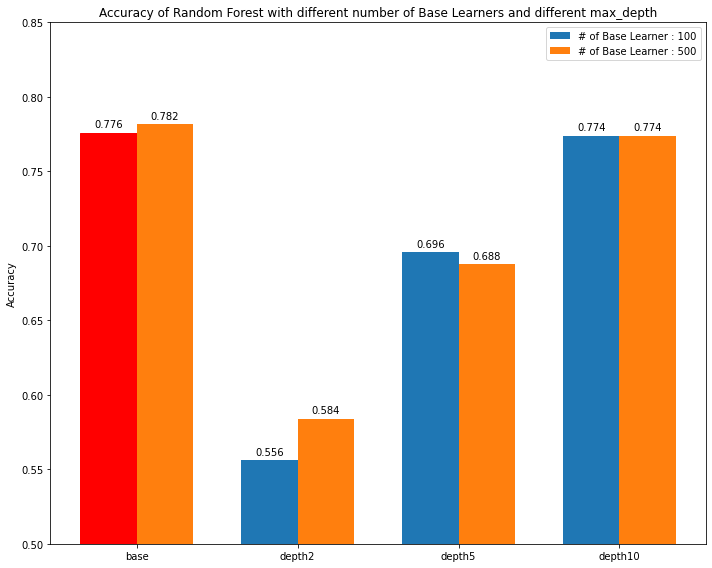

In [42]:
result_vis_dict = rf_result_dict
result_group_1 = {key : value for key, value in result_vis_dict.items() if key in ["base", "depth2", "depth5", "depth10"]}
result_group_2 = {key : value for key, value in result_vis_dict.items() if key in ["base500", "depth2_num500", "depth5_num500", "depth10_num500"]}

x = np.arange(len(result_group_1))
width = 0.35

fig, ax = plt.subplots()


ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Random Forest with different number of Base Learners and different max_depth')
ax.set_xticks(x)
ax.set_xticklabels(result_group_1.keys())
ax.set_ylim(0.5, 0.85)

rects1 = ax.bar(x - width/2, result_group_1.values(), width, label="# of Base Learner : 100")
rects2 = ax.bar(x + width/2, result_group_2.values(), width, label="# of Base Learner : 500")
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.legend()

# change figure size and bar color
fig.set_size_inches(10, 8)
rects1[0].set_color('r')
fig.tight_layout()
plt.show()

Base Learner의 최대 깊이 및 갯수에 따른 성능 변화는 위와 같다. 깊이가 깊어질수록 Base Learner의 갯수는 큰 영향을 미치지 못하는 것을 볼 수 있다. 즉, 깊이가 깊은 Base Learner를 확보하여 과적합된다면, 각 Base Learner 간 다양성이 증대될 것이기 때문에, 많은 양의 Base Learner가 필요하지 않은 것이다. 하지만 Base Learner가 과소적합된 (depth2) 경우, Base Learner의 수를 늘려 다양성을 확보해야 하는 것을 알 수 있다. 

### 2. Bootstrap 효과 
Random Forest는 부트스트랩을 통해 각 트리가 학습 시 사용하는 데이터의 분포를 달리하고 있다. 이러한 특징은 각 Base Learner 간 편향을 줄이는데 효과가 있다고 알려져 있다. 실제로 이러한 효과가 있는지 살펴보자. 

In [45]:
rf_clf_base_no_bootstrap = RandomForestClassifier(n_estimators = 100, bootstrap = False, random_state = 0)
rf_clf_base_no_bootstrap.fit(X_train, y_train)
rf_result_dict["base_no_bootstrap"] = rf_clf_base_no_bootstrap.score(X_test, y_test)

rf_clf_base_no_bootstrap_num500 = RandomForestClassifier(n_estimators = 500, bootstrap = False, random_state = 0)
rf_clf_base_no_bootstrap_num500.fit(X_train, y_train)
rf_result_dict["base_no_bootstrap_num500"] = rf_clf_base_no_bootstrap_num500.score(X_test, y_test)

rf_clf_depth2_no_bootstrap = RandomForestClassifier(n_estimators = 100, max_depth = 2, bootstrap = False, random_state = 0)
rf_clf_depth2_no_bootstrap.fit(X_train, y_train)
rf_result_dict["depth2_no_bootstrap"] = rf_clf_depth2_no_bootstrap.score(X_test, y_test)

rf_clf_depth2_no_bootstrap_num500 = RandomForestClassifier(n_estimators = 500, max_depth = 2, bootstrap = False, random_state = 0)
rf_clf_depth2_no_bootstrap_num500.fit(X_train, y_train)
rf_result_dict["depth2_no_bootstrap_num500"] = rf_clf_depth2_no_bootstrap_num500.score(X_test, y_test)

rf_clf_depth5_no_bootstrap = RandomForestClassifier(n_estimators = 100, max_depth = 5, bootstrap = False, random_state = 0)
rf_clf_depth5_no_bootstrap.fit(X_train, y_train)
rf_result_dict["depth5_no_bootstrap"] = rf_clf_depth5_no_bootstrap.score(X_test, y_test)

rf_clf_depth5_no_bootstrap_num500 = RandomForestClassifier(n_estimators = 500, max_depth = 5, bootstrap = False, random_state = 0)
rf_clf_depth5_no_bootstrap_num500.fit(X_train, y_train)
rf_result_dict["depth5_no_bootstrap_num500"] = rf_clf_depth5_no_bootstrap_num500.score(X_test, y_test)

rf_clf_depth10_no_bootstrap = RandomForestClassifier(n_estimators = 100, max_depth = 10, bootstrap = False, random_state = 0)
rf_clf_depth10_no_bootstrap.fit(X_train, y_train)
rf_result_dict["depth10_no_bootstrap"] = rf_clf_depth10_no_bootstrap.score(X_test, y_test)

rf_clf_depth10_no_bootstrap_num500 = RandomForestClassifier(n_estimators = 500, max_depth = 10, bootstrap = False, random_state = 0)
rf_clf_depth10_no_bootstrap_num500.fit(X_train, y_train)
rf_result_dict["depth10_no_bootstrap_num500"] = rf_clf_depth10_no_bootstrap_num500.score(X_test, y_test)

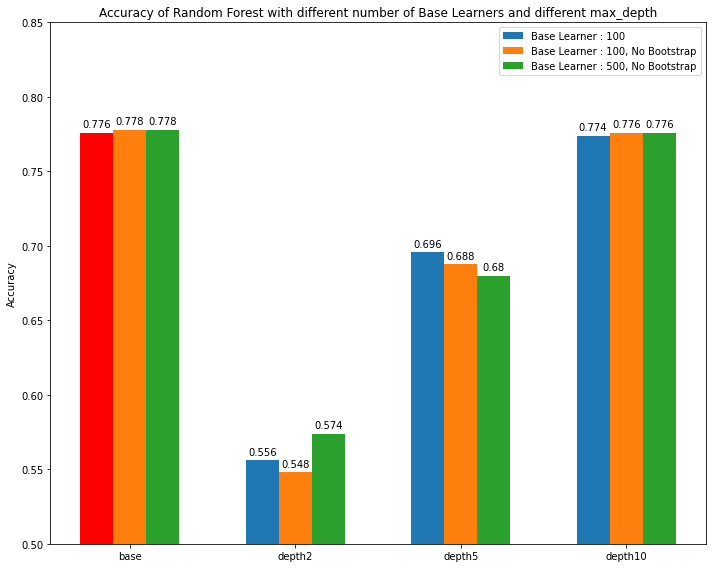

In [47]:
result_vis_dict = rf_result_dict
result_group_1 = {key : value for key, value in result_vis_dict.items() if key in ["base", "depth2", "depth5", "depth10"]}
result_group_2 = {key : value for key, value in result_vis_dict.items() if key in ["base_no_bootstrap", "depth2_no_bootstrap", "depth5_no_bootstrap", "depth10_no_bootstrap"]}
result_group_3 = {key : value for key, value in result_vis_dict.items() if key in ["base_no_bootstrap_num500", "depth2_no_bootstrap_num500", "depth5_no_bootstrap_num500", "depth10_no_bootstrap_num500"]}

x = np.arange(len(result_group_1))
width = 0.2

fig, ax = plt.subplots()


ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Random Forest with different number of Base Learners and different max_depth')
ax.set_xticks(x)
ax.set_xticklabels(result_group_1.keys())
ax.set_ylim(0.5, 0.85)

rects1 = ax.bar(x - width, result_group_1.values(), width, label="Base Learner : 100")
rects2 = ax.bar(x, result_group_2.values(), width, label="Base Learner : 100, No Bootstrap")
rects3 = ax.bar(x + width, result_group_3.values(), width, label="Base Learner : 500, No Bootstrap")
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.legend()

# change figure size and bar color
fig.set_size_inches(10, 8)
rects1[0].set_color('r')
fig.tight_layout()
plt.show()

놀랍게도 부트스트랩을 적용하지 않았을 경우 성능이 더 올라가는 상황이 일부 발생하였다. 이를 정리하면 아래와 같다. 

- Base Learner가 충분히 깊어, 과적합이 가능한 상황이라면, 부트스트랩 여부는 성능에 거의 영향을 미치지 못한다. 
- Base Learner가 깊지 못해, 과적합이 어려운 상황이라면, 부트스트랩은 성능 개선에 큰 영향을 줄 수 있다(depth5).
- Base Learner가 너무 단순하여, 과소적합되는 상황(depth2)라면, 부트스트랩은 성능에 악영향을 미칠 수 있다. 이는 특히 Base Learner의 수가 많을 경우에 해당한다. 

마지막 해석과 관련하여 조금 더 살펴보도록 하자. Depth가 2인 경우, Stump Tree를 Base Learner로 사용하는 것과 동일하다. 이러한 상황에서 Base Learner들은 과소적합되게 된다. 이때, Base Learner의 수가 충분히 많지 않다면(100), bootstrap을 통해 Base Learner의 다양성을 확보할 필요가 있다. 현재 변수가 20개로 다소 적은 상황이기 때문에, 부트스트랩을 적용하지 않는다면 Stump Tree 간 중복이 발생할 수 있기 때문이다. 

하지만 Base Learner가 충분히 많다면(500) Bootstrap을 사용하지 않더라도, 변수 선택의 경우에 따라 다양성이 충분히 발휘될 수 있다. 하지만 그 과정은 매우 비효율적이기 때문에, Base Learner가 과적합이 가능한 상황보다 성능 저하가 발생하게 된다. 

위 결과를 종합해보면 다음과 같은 결론이 가능할 것이다. 

**Random Forest의 성능은 Base Learner의 다양성에서 발생한다. 이 다양성은 크게 각 base learner가 1) 다른 데이터셋에 대해 2) 다른 변수 조합을 이용하여 과적합되도록 유도하는 과정에서 확보된다. 이를 보다 직접적으로 이야기하면, 1) 부트스트랩을 통해 학습  데이터를 다르게 구성하고 2) 각 base learner 분기 시 다른 변수를 이용하도록 하여 과적합되도록 한다. 이때, base learner의 과적합 여부가 가장 큰 요인이며, 데이터의 다양성은 이후 고려 요소일 것이다.**

이를 고려하면 현재 결과를 두가지 해석이 가능하다. 

1. 각 Base Learner가 과적합되지 못한 경우(Depth가 2 또는 5인 경우) 동일한 데이터를 사용하면 비슷한 분기점이 형성되므로 성능 저하가 발생한다. 
2. 각 Base Learner가 과적합된 경우 (Depth가 10 또는 그 이상인 경우) 동일한 데이터를 사용하여도, 분기점이 다르게 형성되므로 성능 향상이 가능하다. 

또한, Base Learner가 과적합되는 경우에, 부트스트랩보다 동일 데이터 사용 시 성능이 향상되는 이유는, 태스크가 비교적 단순하고, 분기점을 다르게 형성하는 2번 전략으로도 충분히 일반화 성능을 확보할 수 있기 때문으로 보인다. 

### 3. 변수 선택 방법론의 효과

Random Forest에서 Base Learner의 다양성을 확보하는 방법론 중 하나인 Bootstrap은 실제로 변수 선택을 다양하게 하는 방법론을 통해 보완되고 있음을 위를 통해 살펴보았다. 그렇다면 변수 선택 방법론을 다양하게 하는 것이 어떠한 효과를 가져오는지 살펴보자. 

In [50]:
rf_clf_base_max_features = RandomForestClassifier(n_estimators = 100, max_features = 1, random_state = 0)
rf_clf_base_max_features.fit(X_train, y_train)
rf_result_dict["base_max_features"] = rf_clf_base_max_features.score(X_test, y_test)

rf_clf_num10_max_features = RandomForestClassifier(n_estimators = 10, max_features = 1, random_state = 0)
rf_clf_num10_max_features.fit(X_train, y_train)
rf_result_dict["base10_max_features"] = rf_clf_num10_max_features.score(X_test, y_test)

rf_clf_num500_max_features = RandomForestClassifier(n_estimators = 500, max_features = 1, random_state = 0)
rf_clf_num500_max_features.fit(X_train, y_train)
rf_result_dict["base500_max_features"] = rf_clf_num500_max_features.score(X_test, y_test)

rf_clf_num1000_max_features = RandomForestClassifier(n_estimators = 1000, max_features = 1, random_state = 0)
rf_clf_num1000_max_features.fit(X_train, y_train)
rf_result_dict["base1000_max_features"] = rf_clf_num1000_max_features.score(X_test, y_test)

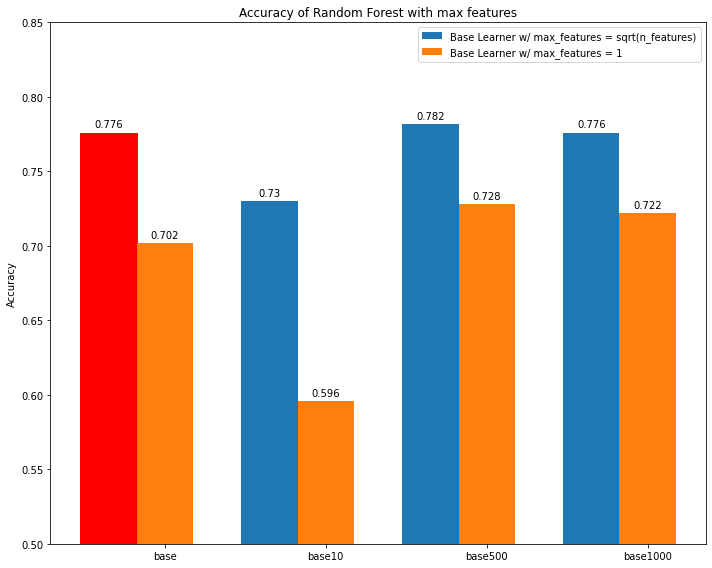

In [49]:
result_vis_dict = rf_result_dict
result_group_1 = {key : value for key, value in result_vis_dict.items() if key in ["base", "base10", "base500", "base1000"]}
result_group_2 = {key : value for key, value in result_vis_dict.items() if key in ["base_max_features", "base10_max_features", "base500_max_features", "base1000_max_features"]}

x = np.arange(len(result_group_1))
width = 0.35

fig, ax = plt.subplots()


ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Random Forest with max features')
ax.set_xticks(x)
ax.set_xticklabels(result_group_1.keys())
ax.set_ylim(0.5, 0.85)

rects1 = ax.bar(x - width, result_group_1.values(), width, label="Base Learner w/ max_features = sqrt(n_features)")
rects2 = ax.bar(x, result_group_2.values(), width, label="Base Learner w/ max_features = 1")
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.legend()

# change figure size and bar color
fig.set_size_inches(10, 8)
rects1[0].set_color('r')
fig.tight_layout()
plt.show()

Random Forest에서 모든 분기점에서 모든 변수를 고려하도록 수정한 실험 결과는 위와 같다. 그 결과 변수 다양성의 효과는 매우 확실한 것으로 드러났다. 매 분기마다 모든 변수를 고려할 경우 base learner의 갯수에 관계없이 성능저하가 발생하는 것으로 관찰되었다. 더 다양한 조건에서 실험을 진행해보자. 

In [51]:
rf_clf_base_max_features_07 = RandomForestClassifier(n_estimators = 100, max_features = 0.7, random_state = 0)
rf_clf_base_max_features_07.fit(X_train, y_train)
rf_result_dict["base_max_features_07"] = rf_clf_base_max_features_07.score(X_test, y_test)

rf_clf_num10_max_features_07 = RandomForestClassifier(n_estimators = 10, max_features = 0.7, random_state = 0)
rf_clf_num10_max_features_07.fit(X_train, y_train)
rf_result_dict["base10_max_features_07"] = rf_clf_num10_max_features_07.score(X_test, y_test)

rf_clf_num500_max_features_07 = RandomForestClassifier(n_estimators = 500, max_features = 0.7, random_state = 0)
rf_clf_num500_max_features_07.fit(X_train, y_train)
rf_result_dict["base500_max_features_07"] = rf_clf_num500_max_features_07.score(X_test, y_test)

rf_clf_num1000_max_features_07 = RandomForestClassifier(n_estimators = 1000, max_features = 0.7, random_state = 0)
rf_clf_num1000_max_features_07.fit(X_train, y_train)
rf_result_dict["base1000_max_features_07"] = rf_clf_num1000_max_features_07.score(X_test, y_test)

rf_clf_base_max_features_04 = RandomForestClassifier(n_estimators = 100, max_features = 0.4, random_state = 0)
rf_clf_base_max_features_04.fit(X_train, y_train)
rf_result_dict["base_max_features_04"] = rf_clf_base_max_features_04.score(X_test, y_test)

rf_clf_num10_max_features_04 = RandomForestClassifier(n_estimators = 10, max_features = 0.4, random_state = 0)
rf_clf_num10_max_features_04.fit(X_train, y_train)
rf_result_dict["base10_max_features_04"] = rf_clf_num10_max_features_04.score(X_test, y_test)

rf_clf_num500_max_features_04 = RandomForestClassifier(n_estimators = 500, max_features = 0.4, random_state = 0)
rf_clf_num500_max_features_04.fit(X_train, y_train)
rf_result_dict["base500_max_features_04"] = rf_clf_num500_max_features_04.score(X_test, y_test)

rf_clf_num1000_max_features_04 = RandomForestClassifier(n_estimators = 1000, max_features = 0.4, random_state = 0)
rf_clf_num1000_max_features_04.fit(X_train, y_train)
rf_result_dict["base1000_max_features_04"] = rf_clf_num1000_max_features_04.score(X_test, y_test)

{'base': 0.776,
 'base10': 0.73,
 'base500': 0.782,
 'base1000': 0.776,
 'depth2': 0.556,
 'depth5': 0.696,
 'depth10': 0.774,
 'depth2_num500': 0.584,
 'depth5_num500': 0.688,
 'depth10_num500': 0.774,
 'base_no_bootstrap': 0.778,
 'base_no_bootstrap_num500': 0.778,
 'depth2_no_bootstrap': 0.548,
 'depth2_no_bootstrap_num500': 0.574,
 'depth5_no_bootstrap': 0.688,
 'depth5_no_bootstrap_num500': 0.68,
 'depth10_no_bootstrap': 0.776,
 'depth10_no_bootstrap_num500': 0.776,
 'base_max_features': 0.702,
 'base10_max_features': 0.596,
 'base500_max_features': 0.728,
 'base1000_max_features': 0.722,
 'base_max_features_07': 0.77,
 'base10_max_features_07': 0.746,
 'base500_max_features_07': 0.772,
 'base1000_max_features_07': 0.772,
 'base_max_features_04': 0.772,
 'base10_max_features_04': 0.758,
 'base500_max_features_04': 0.778,
 'base1000_max_features_04': 0.776}

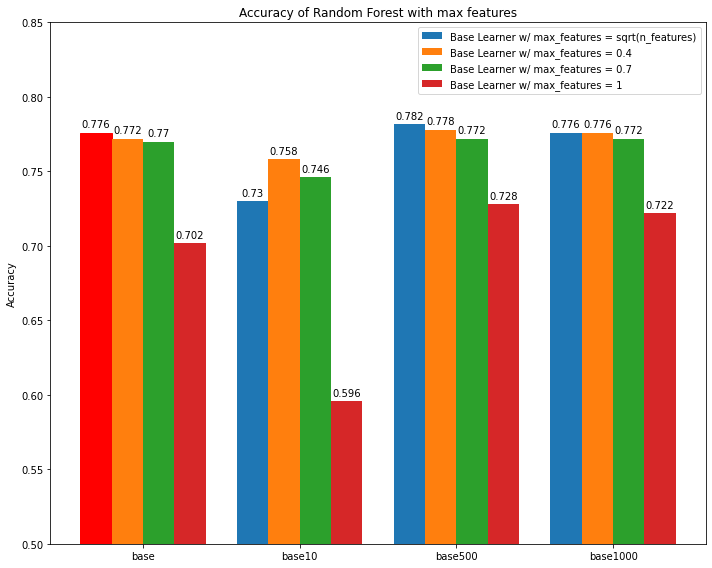

In [57]:
result_vis_dict = rf_result_dict
result_group_1 = {key : value for key, value in result_vis_dict.items() if key in ["base", "base10", "base500", "base1000"]}
result_group_2 = {key : value for key, value in result_vis_dict.items() if key in ["base_max_features_04", "base10_max_features_04", "base500_max_features_04", "base1000_max_features_04"]}
result_group_4 = {key : value for key, value in result_vis_dict.items() if key in ["base_max_features", "base10_max_features", "base500_max_features", "base1000_max_features"]}
result_group_3 = {key : value for key, value in result_vis_dict.items() if key in ["base_max_features_07", "base10_max_features_07", "base500_max_features_07", "base1000_max_features_07"]}

x = np.arange(len(result_group_1))
width = 0.2

fig, ax = plt.subplots()


ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Random Forest with max features')
ax.set_xticks(x)
ax.set_xticklabels(result_group_1.keys())
ax.set_ylim(0.5, 0.85)

rects1 = ax.bar(x - 3/2*width, result_group_1.values(), width, label="Base Learner w/ max_features = sqrt(n_features)")
rects2 = ax.bar(x - 1/2*width, result_group_2.values(), width, label="Base Learner w/ max_features = 0.4")
rects3 = ax.bar(x + 1/2*width, result_group_3.values(), width, label="Base Learner w/ max_features = 0.7")
rects4 = ax.bar(x + 3/2*width, result_group_4.values(), width, label="Base Learner w/ max_features = 1")

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)
ax.legend()

# change figure size and bar color
fig.set_size_inches(10, 8)
rects1[0].set_color('r')
fig.tight_layout()
plt.show()

base learner의 분기점 당 변수 갯수를 다양하게 조절하여 실험한 결과는 위와 같다. 그 결과는 아래와 같다. 

1. 분기점 당 변수 갯수를 늘릴수록, 성능이 저하되는 경향이 존재했다. 
1-1. 1의 경향은 변수를 모두 사용하는 경우에 특히 극심한 성능 저하로 나타났다. 
1-2. 1-1의 결과는 모든 변수를 사용하는 경우 각 base learner 당 다양성이 급격히 감소하기 때문으로 보인다. 
2. base learner의 수가 부족할 경우 분기점당 변수의 갯수는 0.4가 최적이었다. 
2-1. 2의 결과는 base learner의 수가 부족할 경우 각 base learner 간 다양성만틈, 각 base learner의 성능이 중요하기 때문으로 보인다. 


### 4. 결론
위 실험 결과를 종합하면 다음과 같다. 

1. Random Forest의 핵심은 base learner의 다양성 확보에 있다. 
2. base learner의 다양성을 결정하는 요인으론 1) 분기점 당 변수 갯수 2) 최대깊이 3) base learner의 수 4) 부트스트랩이 있다. 
3. 분기점 당 변수 갯수가 가장 중요한 요인이다. 그 이유는 각 base learner가 과적합되었을 때, base learner의 다양성에 직접적 영향을 미치기 때문이다. 
4. 최대깊이가 두번째 중요한 요인이다. 그 이유는 각 base learner가 과적합되지 않는다면, 다양성이 확보되지 않기 떄문이다. 
5. base learner의 수는 세번째 요인이다. 그 이유는 base learner이 **다양하게 과적합되었다**면, base learner의 수를 일정수준까지 확보할수록 Random Forest의 성능이 향상되기 때문이다. 
6. 부트스트랩은 큰 영향력을 가지지 않는다. 그 이유는 이미 base learner의 다양성은 다른 요인들에 의해 확보될 수 있기 때문이다. 